# Large-scale Distributed  k -means Algorithm
In this Notebook, we'll focus on the development of a simple distributed algorithm. As for the Notebook on SGD, we focus on iterative algorithms, which eventually converge to a desired solution.

In what follows, we'll proceed with the following steps:

We first introduce formally the  k -means algorithm
Then we focus on a serial implementation. To do this, we'll first generate some data using scikit. In passing, we'll also use the  k -means implementation in scikit to have a baseline to compare against.
Subsequently, we will focus on some important considerations and improvements to the serial implementation of  k -means.
At this point, we'll design our distributed version of the  k -means algorithm using pyspark, and re-implement the enhancements we designed for the serial version

<b>References:</b><br>
- https://en.wikipedia.org/wiki/K-means_clustering
- http://nbviewer.jupyter.org/github/ethen8181/machine-learning/blob/master/clustering/kmeans.ipynb
- https://apache.googlesource.com/spark/+/master/examples/src/main/python/kmeans.py
- https://github.com/castanan/w2v/blob/master/ml-scripts/w2vAndKmeans.py

<br>
<b>Preamble code</b>

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import pairwise_distances_argmin, euclidean_distances
from sklearn.datasets.samples_generator import make_blobs
import time

# Preliminaries: the  k -means algorithm
k -means clustering aims to partition  n   d− dimensional observations into  k  clusters in which each observation belongs to the cluster with the nearest mean, serving as a prototype of the cluster. This results in a partitioning of the data space into Voronoi cells. The problem is computationally difficult (NP-hard); however, there are efficient heuristic algorithms that are commonly employed and converge quickly to a local optimum. In this Notebook we'll focus on one of them in particular: the Lloyd algorithm.

The  k -means problem can be formalized as follows. Given a set of observations  (x1,x2,⋯,xn) , where each observation is a  d -dimensional real vector,  k -means clustering aims to partition the  n  observations into  k≤n  sets  S={S1,S2,⋯,Sk}  so as to minimize the within-cluster sum of squares (WCSS) (i.e. variance). 

The most common algorithm uses an iterative refinement technique. Given an initial set of  k  centroids  μ(1)1,⋯,μ(1)k  , the algorithm proceeds by alternating between two steps: in the assignment step, observations are associated to the closest centroid, in terms of squared Euclidean distance; in the update step new centroids are computed based on the new points associated to each centroid. Note:  μ(t)i  stands for the  i -th centroid as of the  t -th iteration. So  μ(1)1  is the centroid 1 at iteration 1.

# Synthetic data generation: working in bi-dimensional spaces
Next, we use sklearn to generate some synthetic data to test our algorithm.

In [2]:
X, y = make_blobs(n_samples = 300, centers = 4,
                  random_state = 0, cluster_std = 0.6)

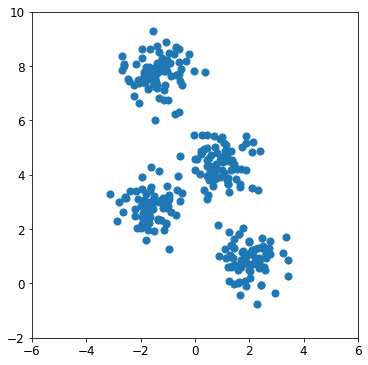

In [3]:
# change default figure and font size
plt.rcParams['figure.figsize'] = 8, 6 
plt.rcParams['font.size'] = 12

# scatter plot
plt.scatter(X[:, 0], X[:, 1], s = 50)
plt.ylim(-2, 10)
plt.xlim(-6, 6)
plt.gca().set_aspect('equal')
plt.show()

<div class="alert alert-block alert-info">
<b>Question 1.</b> Implement your own version of k-means, as a serial algorithm. Follow the guidelines below:
- Define a function to perform k-means clustering. The function should accept as inputs: the training data x, the number of clusters k, and the iteration budget you allocate to the algorithm. Additional arguments might include the use of a random seed to initialize centroids.
- The function should output the centroids, and the cluster assignment, that is, to which centroid each data point is assigned to
- Optionally, keep track of the position of the centroids, for each iteration.


Once the ```kmeans``` function is defined, you can generate input data according to the cell above, that uses scikitlearn. 
- The output of your cell should contain the following information:
- Print the number of data points that belong to each cluster
- Plot the clustered data points:
    - Using different colors for each cluster
    - Plot the centroid positions for each cluster

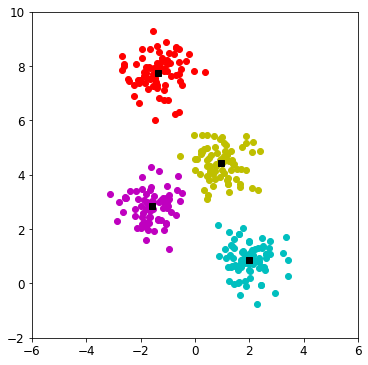

In [4]:
def kmeans(X, k, maxiter, seed=1): #X = training data, k = number of clusters, maxiter = max number of iterations
    """
    specify the number of clusters k and
    the maximum iteration to run the algorithm
    """

    # randomly choose k data points as initial centroids
    np.random.seed(seed)
    centroidsIndices = np.random.permutation(X.shape[0])
    centroids = np.array([]) 
    for i in range(k):
        centroids = np.append(centroids, X[centroidsIndices[i]])
    centroids = centroids.reshape(k,2)
    
    
    for itr in range(maxiter):
        # ---------------
        # ASSIGNMENT STEP
        # ---------------
        # compute the distance matrix between each data point and the set of centroids
        distance_matrix = np.array([])
        for i in X:
            for j in centroids:
                #print ("value of i")
                #print (i)
                #print ("value of j") 
                #print (j)
                dist = np.sqrt((j[0] - i[0])**2 + (j[1] - i[1])**2)
                #print ("distance of i'th X from j'th centroid")
                #print (dist)
                distance_matrix = np.append(distance_matrix, dist)
        distance_matrix = distance_matrix.reshape(X.shape[0],k)

        # row Index = data point Index; col Index = centroid Index; value=distance
        
        # assign each data point to the closest centroid
        # note: k centroids so the index goes from 0 to k-1. it's the column with the smallest value in each array
        cluster_assignment = np.array([])
        for row in distance_matrix:
            temp = row[0]
            colIndex = 0;
            for i in range(len(row)):
                if temp > row[i]:
                    temp = row[i]
                    colIndex= i
            cluster_assignment = np.append(cluster_assignment, colIndex)

        # array Index = data point Index; array value = closest centroid Index

        # UPDATE STEP
        # select all data points that belong to cluster i and compute
        # the mean of these data points (each feature individually)
        # this will be our new cluster centroids
        new_centroids = np.array([])
        for clusterIndex in range(k):
            tempArray = np.array([])
            for i in range(len(cluster_assignment)):
                if int(cluster_assignment[i]) == clusterIndex:
                    tempArray = np.append(tempArray, X[i])

            tempArray = tempArray.reshape(int(tempArray.shape[0]/2), 2)
            new_centroids = np.append(new_centroids,tempArray.mean(axis=0))
            
            # still need to take the average of all of them and reassign centroids
        
        new_centroids = new_centroids.reshape(k,2)
        # STOP CONDITION
        if np.array_equal(centroids,new_centroids):
            break
        else:
            centroids = new_centroids

    return cluster_assignment,centroids

k = 4
cluster_assign, centroidList = kmeans(X, k, 20)

# Plot the clustered data points:
colorList = ['ro', 'co', 'mo', 'yo']
for clusterNum in range(k):
    for idx, cluster in enumerate(cluster_assign):
        if cluster == clusterNum:
            plt.plot(X[idx][0],X[idx][1], colorList[clusterNum])

for centroid in centroidList:
    plt.plot(centroid[0],centroid[1],'ks')
plt.ylim(-2,10)
plt.xlim(-6,6)
plt.gca().set_aspect('equal')
plt.show()

<div class="alert alert-block alert-info">
<b>Question 2.</b> Use the built-in k-means implementation in sklearn and determine centroids and clusters. Follow the guidelines below:
- Use the KMeans algorithm from sklearn
- Use the fit_predict method to cluster data
- Use the cluster_centers_ method to retrieve centroids

The output of your cell should contain the following information:
- Plot the clustered data points, using the same code your have produced for Question.1
    - Using different colors for each cluster
    - Plot the centroid positions for each cluster

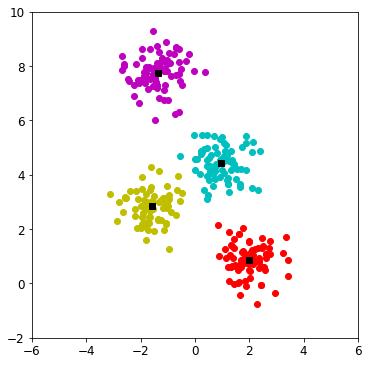

In [5]:
kmeans_skl = KMeans(n_clusters = k, random_state=0).fit(X)

colorList = ['ro', 'co', 'mo', 'yo']
for clusterNum in range(k):
    for idx, cluster in enumerate(kmeans_skl.labels_):
        if cluster == clusterNum:

            plt.plot(X[idx][0],X[idx][1], colorList[clusterNum])

for centroid in kmeans_skl.cluster_centers_:
    plt.plot(centroid[0],centroid[1],'ks')

plt.ylim(-2,10)
plt.xlim(-6,6)
plt.gca().set_aspect('equal')
plt.show()

<div class="alert alert-block alert-info">
<b>Question 3.</b> Use the sklearn dataset API to generate alternative synthetic data to test your k-means algorithm implementation. Follow the guidelines from this document: http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py The output of your cell should contain the following information:
- Plot the new synthetic dataset you generated
- Plot the clustered data points, using the same code your have produced for Question.1
    - Using different colors for each cluster
    - Plot the centroid positions for each cluster

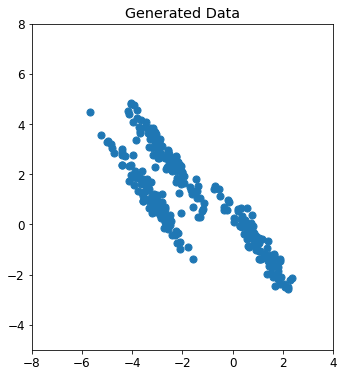

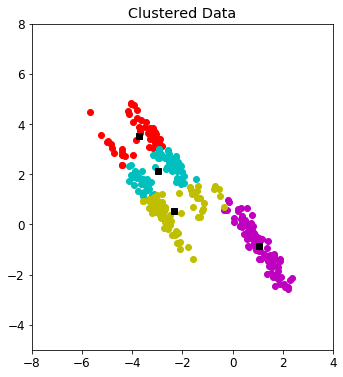

In [6]:
random_state = 170
X2, y2 = datasets.make_blobs(n_samples=300, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X2, transformation)

# scatter plot
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], s = 50)
plt.ylim(-5, 8)
plt.xlim(-8, 4)
plt.gca().set_aspect('equal')
plt.title("Generated Data")
plt.show()

cluster_assign2, centroidList2 = kmeans(X_aniso, k, 20)



# Plot the clustered data points:
colorList = ['ro', 'co', 'mo', 'yo']
for clusterNum in range(k):
    for idx, cluster in enumerate(cluster_assign2):
        if cluster == clusterNum:
            plt.plot(X_aniso[idx][0],X_aniso[idx][1], colorList[clusterNum])

for centroid in centroidList2:
    plt.plot(centroid[0],centroid[1],'ks')
plt.ylim(-5, 8)
plt.xlim(-8, 4)
plt.gca().set_aspect('equal')
plt.title("Clustered Data")
plt.show()

# A simplified analysis of algorithm convergence
One well-known weakness of  k -means is that the algorithm's performance is closely tied with the randomly generated initial centroids' quality. If the algorithm starts with a set of bad inital centers, it will get stuck in a local minimum.

Instead of taking a formal approach to study the convergence of  k -means, let's study it with an experimental approach. One thing we can do is to build a measure of clustering quality: intuitively, a good clustering result should produce clusters in which data points should be very close to their centroids, and very far from other centroids. In this Notebook, we'll look at a metric called the total within Sum of Squares, which is sometimes referred ot as heterogeneity.

<div class="alert alert-block alert-info">
<b>Question 4.</b> Modify your own version of k-means, to compute heterogeneity as defined above. Follow the guidelines below:
- Use the same method template you used in Question 1
- Add the code required to compute heterogeneity
- The function should return, in addition to the same return values as for the baseline version, the computed heterogeneity

Computed Heterogeneity:
[ 222.89386306]


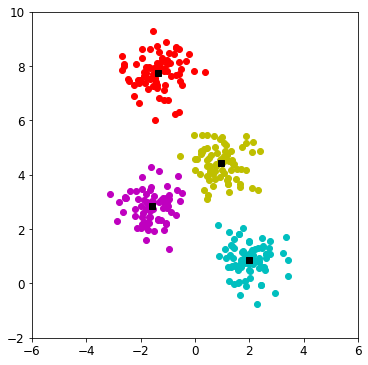

In [7]:
def kmeansHet(X, k, maxiter, seed = 0): #X = training data, k = number of clusters, maxiter = max number of iterations
    """
    specify the number of clusters k and
    the maximum iteration to run the algorithm
    """

    # randomly choose k data points as initial centroids
    np.random.seed(seed)
    centroidsIndices = np.random.permutation(X.shape[0])
    centroids = np.array([])
    for i in range(k):
        centroids = np.append(centroids, X[centroidsIndices[i]])
    centroids = centroids.reshape(k,2)
        
    for itr in range(maxiter):
        # ---------------
        # ASSIGNMENT STEP
        # ---------------
        # compute the distance matrix between each data point and the set of centroids
        distance_matrix = np.array([])
        for i in X:
            for j in centroids:
                dist = np.sqrt((j[0] - i[0])**2 + (j[1] - i[1])**2)
                distance_matrix = np.append(distance_matrix, dist)
        distance_matrix = distance_matrix.reshape(X.shape[0],k)

        # row Index = data point Index; col Index = centroid Index; value=distance
        
        # assign each data point to the closest centroid
        # note: k centroids so the index goes from 0 to k-1. it's the column with the smallest value in each array
        cluster_assignment = np.array([])
        for row in distance_matrix:
            temp = row[0]
            colIndex = 0;
            for i in range(len(row)):
                if temp > row[i]:
                    temp = row[i]
                    colIndex= i
            cluster_assignment = np.append(cluster_assignment, colIndex)
        
        # array Index = data point Index; array value = closest centroid Index

        # UPDATE STEP
        # select all data points that belong to cluster i and compute
        # the mean of these data points (each feature individually)
        # this will be our new cluster centroids
        new_centroids = np.array([])
        for clusterIndex in range(k):
            tempArray = np.array([])
            for i in range(len(cluster_assignment)):
                if int(cluster_assignment[i]) == clusterIndex:
                    tempArray = np.append(tempArray, X[i])

            tempArray = tempArray.reshape(int(tempArray.shape[0]/2), 2)
            new_centroids = np.append(new_centroids,tempArray.mean(axis=0))

            
            # still need to take the average of all of them and reassign centroids
        new_centroids = new_centroids.reshape(k,2)

        # STOP CONDITION
        if np.array_equal(centroids,new_centroids):
            break
        else:

            centroids = new_centroids
        
    # Print out the number of data points that belong to each cluster

    h = 0
    for idx, centroid in enumerate(centroids):
        positions = X[np.where(cluster_assignment == idx)]

        h += sum(euclidean_distances(positions,centroid.reshape(1,-1)))

    return h,cluster_assignment,centroids

k = 4
het, cluster_assign, centroidList = kmeansHet(X, k, 20, 1)

print("Computed Heterogeneity:")
print(het)

# Plot the clustered data points:
colorList = ['ro', 'co', 'mo', 'yo']
for clusterNum in range(k):
    for idx, cluster in enumerate(cluster_assign):
        if cluster == clusterNum:
            plt.plot(X[idx][0],X[idx][1], colorList[clusterNum])

for centroid in centroidList:
    plt.plot(centroid[0],centroid[1],'ks')
plt.ylim(-2,10)
plt.xlim(-6,6)
plt.gca().set_aspect('equal')
plt.show()


<div class="alert alert-block alert-info">
<b>Question 5.</b> Using the modified k-means method you designed, study algorithm convergence as a function of heterogeneity. Follow the guidelines below:
- Run the modified k-means for at least 5 different initial seed values
- Prepare a dictionary data structure containing: key = random seed, value = heterogeneity
- Print seed, heterogeneity values
- Add your personal comment about the convergence properties of the  k -means algorithm.

In [8]:
hDict = dict()

for i in range(10):
    het, cluster_assign, centroidListH = kmeansHet(X, k, 20, i*10)
    hDict[i*10] = het[0]
    
print (hDict)

{0: 345.61688407840046, 10: 222.89386306068897, 20: 222.89386306068897, 30: 222.89386306068897, 40: 222.89386306068897, 50: 222.89386306068897, 60: 222.89386306068897, 70: 222.893863060689, 80: 222.89386306068897, 90: 222.89386306068897}


## Comments
We ran the modified k-means method ten times to find the heterogeneity value for seeds from 0 to 90 (incremented by 10). We found that it converged 7 out of 10 times, to a value of 233.89, while the other 3 times it did not arrive at the same value after 20 iterations. This is to be expected due to the fact that for a few cases, our initial centroids led us to a local minimum.

# A technique for a smart centroid initialization:  k -means++
One effective way to produce good initial centroids to feed to  k -means is to proceed as follows: instead of randomly generating initial centroids, we will try to spread them out in our  d -dimensional space, such that they are not "too close" to eachother. If you are interested in the details of this technique, you should refer to the link to the original research paper below: in summary, the  k -means++ technique allows to improve the quality of the local optima in which  k -means settles, and to reduce the average runtime of the algorithm.

k-means++: the advantages of careful seeding, by David Arthur and Sergei Vassilvitskii (Stanford University) https://dl.acm.org/citation.cfm?id=1283494

A simplified workflow of the  k -means++ approach is as follows:
- Choose a data point at random from the dataset, this serves as the first centroid
- Compute the squared euclidean distance of all other data points to the randomly chosen first centroid
- To generate the next centroid, each data point is chosen with the probability (weight) of its squared distance to the chosen center in the current round, divided by the the total squared distance (this is just a normalization to make sure the probability adds up to 1). In other words, a new centroid should be as far as possible from the other centroids
- Next, recompute the probability (weight) of each data point as the minimum of the distance between it and all the centers that are already generated (e.g. for the second iteration, compare the data point's distance between the first and second center and choose the smaller one)
- Repeat step 3 and 4 until we have  k  initial centroids to feed to the  k -means algorithm

<div class="alert alert-block alert-info">
<b>Question 6.</b> Modify your own version of k-means, to introduce the smart initialization technique described above. Don't forget to keep track of heterogeneity as well! The whole point is to measure if k-means++ really improves on this metric. 

Follow the guidelines below:
- Use the same method template you used in Question 1
- Add the code required to compute the initial clusters according to k-means++
- Add the code required to compute heterogeneity
- The function should return, in addition to the same return values as for the baseline version, the computed heterogeneity

In [9]:
def kmeans_pp(X, k, maxiter, seed=0): #X = training data, k = number of clusters, maxiter = max number of iterations

    ## BEGIN INITIAL CENTROID GENERATION 

    # randomly choose 1 initial data point, make it the first centroid
    np.random.seed(seed)
    firstRandIdx = np.random.randint(0,len(X)) # Return random integers from low (inclusive) to high (exclusive).
    centroid = X[firstRandIdx]
    centroids = [centroid]

    # generate the rest of the initial centroids
    for i in range (k-1):
        sq_euclid_dists = [] 

        for point in X: 
            sq_euclid_dists.append(min(map(lambda cent: np.linalg.norm(cent-point)**2, centroids)))

        total_sq_dist = sum(sq_euclid_dists)
        norm_sq_euclid_dists = [p / total_sq_dist for p in sq_euclid_dists] # normalize to get probability vector
        norm_sq_euclid_dists = np.array(norm_sq_euclid_dists) # make it numpy

        chosen_idx = np.random.choice(len(X), p=norm_sq_euclid_dists) # choose another index with probability vector passed as p
        chosen_pt = X[chosen_idx]
        centroids.append(chosen_pt)

    centroids = np.array(centroids)
    # END OF CENTROID GENERATION
        
    for itr in range(maxiter):
        # ---------------
        # ASSIGNMENT STEP
        # ---------------
        # compute the distance matrix between each data point and the set of centroids
        distance_matrix = np.array([])
        for i in X:
            for j in centroids:
                dist = np.sqrt((j[0] - i[0])**2 + (j[1] - i[1])**2)
                distance_matrix = np.append(distance_matrix, dist)
        distance_matrix = distance_matrix.reshape(X.shape[0],k)

        # row Index = data point Index; col Index = centroid Index; value=distance
        
        # assign each data point to the closest centroid
        # note: k centroids so the index goes from 0 to k-1. it's the column with the smallest value in each array
        cluster_assignment = np.array([])
        for row in distance_matrix:
            temp = row[0]
            colIndex = 0;
            for i in range(len(row)):
                if temp > row[i]:
                    temp = row[i]
                    colIndex= i
            cluster_assignment = np.append(cluster_assignment, colIndex)
        
        # array Index = data point Index; array value = closest centroid Index

        # UPDATE STEP
        # select all data points that belong to cluster i and compute
        # the mean of these data points (each feature individually)
        # this will be our new cluster centroids
        new_centroids = np.array([])
        for clusterIndex in range(k):
            tempArray = np.array([])
            for i in range(len(cluster_assignment)):
                if int(cluster_assignment[i]) == clusterIndex:
                    tempArray = np.append(tempArray, X[i])

            tempArray = tempArray.reshape(int(tempArray.shape[0]/2), 2)
            new_centroids = np.append(new_centroids,tempArray.mean(axis=0))
            
            # still need to take the average of all of them and reassign centroids
        new_centroids = new_centroids.reshape(k,2)
        # STOP CONDITION
        if np.array_equal(centroids,new_centroids):
            break
        else:
            centroids = new_centroids
    h = 0
    for idx, centroid in enumerate(centroids):
        positions = X[np.where(cluster_assignment == idx)]
        h += sum(euclidean_distances(positions,centroid.reshape(1,-1)))

    return h,cluster_assignment,centroids
    
h_pp, cluster_pp, centroid_pp = kmeans_pp(X, k, 20, 2)

print("Computed heterogeneity:")
print(h_pp[0])
print("Cluster assignments:")
print(cluster_pp)
print("Centroids:")
print(centroid_pp)

Computed heterogeneity:
222.893863061
Cluster assignments:
[ 0.  1.  3.  1.  0.  0.  2.  3.  1.  1.  2.  1.  3.  1.  0.  3.  3.  0.
  2.  2.  0.  0.  3.  2.  2.  3.  0.  3.  2.  3.  1.  1.  3.  1.  1.  1.
  1.  1.  2.  0.  3.  2.  3.  3.  2.  2.  1.  2.  1.  0.  2.  0.  1.  0.
  0.  2.  1.  2.  1.  0.  1.  3.  1.  2.  2.  2.  1.  0.  1.  2.  3.  2.
  1.  2.  2.  1.  2.  3.  0.  1.  0.  3.  0.  0.  1.  3.  0.  3.  1.  1.
  3.  0.  1.  2.  2.  3.  0.  0.  3.  2.  1.  0.  1.  0.  3.  0.  0.  3.
  1.  3.  2.  2.  0.  1.  0.  3.  1.  0.  0.  3.  2.  0.  2.  0.  0.  0.
  0.  2.  0.  2.  1.  2.  2.  0.  1.  2.  2.  1.  3.  1.  1.  2.  3.  2.
  3.  2.  1.  3.  1.  1.  1.  3.  1.  3.  0.  2.  1.  2.  0.  3.  1.  3.
  3.  0.  3.  2.  2.  3.  0.  3.  3.  1.  0.  3.  2.  1.  0.  0.  3.  2.
  0.  3.  2.  2.  3.  3.  3.  3.  0.  1.  3.  2.  3.  3.  2.  2.  2.  3.
  2.  1.  3.  2.  0.  2.  3.  1.  2.  1.  3.  1.  3.  2.  3.  3.  1.  2.
  2.  0.  0.  3.  1.  0.  0.  2.  0.  2.  3.  1.  1.  3.  3.  1. 

<div class="alert alert-block alert-info">
<b>Question 7.</b> Similarly to question 5, using the modified k-means method you designed, study algorithm convergence as a function of heterogeneity. 

Follow the guidelines below:
- Run the modified k-means for at least 5 different initial seed values
- Prepare a dictionary data structure containing: key = random seed, value = heterogeneity
- Print seed, heterogeneity values

One additional question to answer is the following: print the average heterogeneity for the baseline k-means algorithm, and the average heterogeneity when using the k-means++ initialization. Compare and comment with your own words.

In [10]:
normal_het_dict = dict()
pp_het_dict = dict()
normalTempSum = 0
ppTempSum = 0
rangeNumber = 30

for i in range(rangeNumber):
    het, cluster_assign, centroidListH = kmeansHet(X, k, 20, i*20)
    normal_het_dict[i*20] = het[0]
    normalTempSum += het[0]

    het, cluster_assign, centroidListH = kmeans_pp(X, k, 20, i*20) 
    pp_het_dict[i*20] = het[0]
    ppTempSum += het[0]

normalAvg = normalTempSum/rangeNumber
ppAvg = ppTempSum/rangeNumber

print("Normal k-means heterogeneity: ")    
print (normal_het_dict)
print("Modified k-means++ heterogeneity:")
print (pp_het_dict)


print("Average heterogeneity for baseline k-means: ")
print (normalAvg)
print("Average heterogeneity for k-means++: ")
print (ppAvg)

Normal k-means heterogeneity: 
{0: 345.61688407840046, 20: 222.89386306068897, 40: 222.89386306068897, 60: 222.89386306068897, 80: 222.89386306068897, 100: 222.89386306068897, 120: 222.89386306068897, 140: 222.89386306068897, 160: 222.89386306068897, 180: 222.89386306068897, 200: 222.89386306068897, 220: 341.2762052098908, 240: 345.33031591865688, 260: 341.2491079096942, 280: 222.89386306068897, 300: 341.27620520989086, 320: 222.893863060689, 340: 345.57647474655158, 360: 222.89386306068897, 380: 341.2491079096942, 400: 222.89386306068897, 420: 222.89386306068897, 440: 222.89386306068897, 460: 341.27620520989086, 480: 222.89386306068897, 500: 222.89386306068897, 520: 222.893863060689, 540: 222.89386306068897, 560: 222.89386306068897, 580: 222.89386306068897}
Modified k-means++ heterogeneity:
{0: 222.89386306068897, 20: 222.89386306068897, 40: 341.27620520989086, 60: 222.89386306068897, 80: 222.89386306068897, 100: 222.89386306068897, 120: 222.893863060689, 140: 222.89386306068897, 160:

## Comments
With the baseline k-means algorithm, we see the average heterogeneity for a range of 30 of 254.88, while the k-means++ algorithm has an average heterogeneity of 238.82, a difference of around 16. This signifies that, as expected, k-means++ is doing a better job of initializing the centroids as compared to standard k-means since a lower heterogeneity means that the points are clustered closer to the centroid. We can see this because an average heterogeneity that is closer to the heterogeneity of the optimum solution (i.e. the lower the average is), the more often the algorithm converges to the optimum, as opposed to getting stuck in a local minimum.

# Determining the value of k: a simple and visual approach, called the Elbow method
Another problem of  k -means is that we have to specify the number of clusters  k  before running the algorithm, which we often don't know a priori. There are many different heuristics for choosing a suitable value for  k , the simplest one being the Elbow method. Essentially, the idea is to run the  k -means algorithm using different values of  k  and plot the corresponding heterogeneity. This measure will decrease as the number of clusters increases, because each cluster will be smaller and tighter. By visual inspection of the plot heterogeneity vs.  k , we will (hopefully!) see that the curve flattens out at some value of  k : this is what we call an "elbow", and we'll select the value of  k  corresponding to the "elbow" position.

<div class="alert alert-block alert-info">
<b>Question 8.</b> Using the k-means algorithm you implemented, including the smart initialization technique, collect into an array the value of heterogeneity as a function of the number of clusters k, where k is to be selected in the range [2,10]. 

Your output cell should contain:
- The plot of heterogeneity vs. k
- A discussion on your visual inspection of the curve, together with a justification for an appropriate choice of the value k

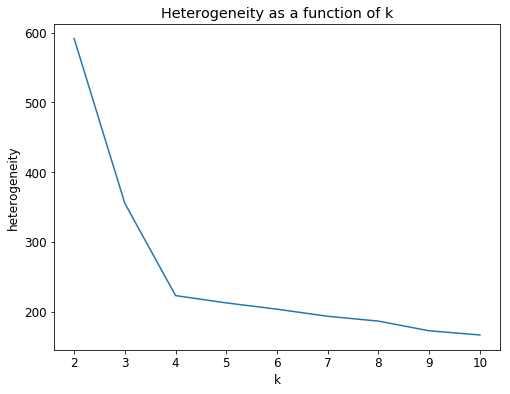

In [11]:
k_het_dict = dict()
for new_k in range(2,11):
    het, cluster_assign, centroidListH = kmeans_pp(X, new_k, 20) 
    k_het_dict[new_k] = het[0]

k_het_list = sorted(k_het_dict.items())
x_k,y_het = zip(*k_het_list)


plt.plot(x_k,y_het)
plt.title("Heterogeneity as a function of k")
plt.xlabel("k")
plt.ylabel("heterogeneity")

plt.show()

## Comments
The plot above drops sharply up to a certain point, at which point it levels out to a much gentler slope, much like an elbow. As the turning point is at k=4, we can select 4 to be the optimal number of clusters. This is also expected based on what we already know of our initial data set, which was set up to contain four blobs. 

A value of k lower than 4 would result in high heterogeneity, i.e. the number of clusters are too low to accurately group the data set and there will be many points that are far from any centroid center, in turn increasing the heterogeneity. Anything higher would not result in a much bigger drop in heterogeneity, suggesting that any new clusters beyond the initial four would only serve to break up an existing cluster, not leading to any new information about the position of clusters.

# Distributed  k -means with PySpark
We're now ready to work on a distributed implmentation of the  k -means algorithm, using the PySpark API.

By now, you should be rather familiar with the  k -means algorithm, which means we can focus on its parallel and distributed design.

The basic idea of distributed  k -means is as follows: data points to be clustered should be stored as a distributed dataset, namely a RDD. As in the Notebook on distributed SGD, we will take a shortcut and avoid using HDFS RDDs: rather, we'll use sklearn to generate the data points, similary to the serial version of the algorithms, then use the parallelize() method to create an RDD, and determine the number of partitions.

We also need to manipulate the centroids array: indeed, all machines should hold a copy of the centroid vector, such that they can proceed independently and in parallel in the first phase of the  k -means algorithm, that is the assignment step. Specifically, every worker has a set of data points, and it will use a copy of the centroid vector to compute cluster assignement: we compute the distance between each data point and each centroid, to assign data points to their closest centroid.

Once the assignement step is done, we need to recompute new centroids based on the assignement, that is, we execute the update step. Clearly, we will need to shuffle data over the network such that we will have, for each current centroid, the list of all data points that have been assigned to it. If you think about it, this problem should be familiar!! This is very similar to what we do in the Word Count example. As such, you will need to make sure the output of the update step is cast to a <key, value> type, where the key corresponds to a centroid identifier, and the value contains the list of data points associated to that centroid. The framework will take care of the distributed group by operation, and organize data according to the semantic of our algorithm.

NOTE: since we will (potentially) work on large dataset sizes, we don't want our algorithm to return the final assignement after convergence, for otherwise we would need to collect a large amount of data in the driver machine, which has a finite and somehow limited amount of RAM.

<div class="alert alert-block alert-info">
<b>Question 9.</b> Implement the distributed version of the k-means algorithm. 

Your output cell should contain:
- The value of the centroids once the algorithm converges
- The total runtime of the distributed algorithm, in seconds
- A visualization of the data points and the computed centroids

In [ ]:
seed = 0
maxiter = 20


import pyspark as py
from operator import add
import time


def assignmentStep(iterable):
    print("starting worker function")
    iterable = np.asarray(list(iterable));
    print("working on")
    print(iterable)
    centroids = bcCentroids.value

    # ---------------
    # ASSIGNMENT STEP
    # ---------------
    # compute the distance matrix between each data point and the set of centroids
    distance_matrix = np.array([])
    for i in iterable:
        for j in centroids:
            dist = np.sqrt((j[0] - i[0])**2 + (j[1] - i[1])**2)
            #print ("distance of i'th X from j'th centroid")
            #print (dist)
            distance_matrix = np.append(distance_matrix, dist)
    distance_matrix = distance_matrix.reshape(iterable.shape[0],k)
    
    # row Index = data point Index; col Index = centroid Index; value=distance
    
    # assign each data point to the closest centroid
    # note: k centroids so the index goes from 0 to k-1. it's the column with the smallest value in each array
    cluster_assignment = np.array([])
    for row in distance_matrix:
        temp = row[0]
        colIndex = 0;
        for i in range(len(row)):
            if temp > row[i]:
                temp = row[i]
                colIndex= i
        cluster_assignment = np.append(cluster_assignment, colIndex)
    
    new_centroids = np.array([])
    countList = []
    sumList = []

    for clusterIndex in range(k):
        countList.append(0)
        sumList.append([0,0])
        for i in range(len(cluster_assignment)):
            if int(cluster_assignment[i]) == clusterIndex:
                sumList[clusterIndex] += iterable[i]
                countList[clusterIndex] += 1


    sumCountList = []
    
    for centroidID in range(k):
        sumCountList.append((centroidID, [sumList[centroidID], countList[centroidID]]))
    

    yield sumCountList

startTime = time.time()
rdd = sc.parallelize(X, 4) # distributes data to 4 diff workers
rdd.cache

## BEGIN INITIAL CENTROID GENERATION 
# randomly choose 1 initial data point, make it the first centroid

np.random.seed(seed)
firstRandIdx = np.random.randint(0,len(X)) # Return random integers from low (inclusive) to high (exclusive).
centroid = X[firstRandIdx]
centroids = [centroid]

# generate the rest of the initial centroids
for i in range (k-1):
    sq_euclid_dists = [] 

    for point in X: 
        sq_euclid_dists.append(min(map(lambda cent: np.linalg.norm(cent-point)**2, centroids)))
    total_sq_dist = sum(sq_euclid_dists)
    norm_sq_euclid_dists = [p / total_sq_dist for p in sq_euclid_dists] # normalize to get probability vector
    norm_sq_euclid_dists = np.array(norm_sq_euclid_dists) # make it numpy

    chosen_idx = np.random.choice(len(X), p=norm_sq_euclid_dists) # choose another index with probability vector passed as p
    chosen_pt = X[chosen_idx]
    centroids.append(chosen_pt)
        
centroids = np.array(centroids)

# END OF CENTROID GENERATION


for itr in range(maxiter): # This for loop is executed by the driver
    bcCentroids = sc.broadcast(centroids) # Use broadcast variables
    
    closest = rdd.mapPartitions(assignmentStep) # This should happen in parallel
    flatClosest = closest.flatMap(lambda x: x)
    closest=flatClosest
    
    newCentroids = flatClosest.reduceByKey(lambda x,y: [np.add(x[0],y[0]), x[1] + y[1]])  # This should happen in parallel
    newCentroids = newCentroids.map(lambda x: (x[0], x[1][0]/x[1][1])).collect() # This should happen in parallel
    
    newCentroids = [cent[1] for cent in newCentroids]
    if np.array_equal(centroids,newCentroids):
        break
    centroids = newCentroids
    # Here we collect new centroids in the driver

endTime = time.time()

totalTime = endTime - startTime

print("Values of Centroids After Convergence:")
print(centroids)

print("Total run time:")
print(totalTime)


# change default figure and font size
plt.rcParams['figure.figsize'] = 8, 6 
plt.rcParams['font.size'] = 12

# scatter plot
plt.scatter(X[:, 0], X[:, 1], s = 50)


for centroid in centroids:
    plt.plot(centroid[0],centroid[1],'rs')
plt.ylim(-2,10)
plt.xlim(-6,6)
plt.gca().set_aspect('equal')
plt.show()

<div class="alert alert-block alert-info">
<b>Question 10.</b> Answer the following questions: 

- How many partitions did you use? Why?
<br>We used four partitions to split up the data between our four workers.
- What is the size of the dataset you generate? Did you cache the dataset? What's the RAM occupation?
<br>We generated a dataset (X) of 300 points, and we did cache it because X is a relatively small dataset that we use iteratively in our loop. It makes sense to cache it to make sure it persists in memory for all iterations of the loop. The RAM occupation for each worker is around 1.2 GB, and for the master, around 500 MB.
- What is the size of the shuffle data over the network? How does it compare to the dataset size?
<br>Each of the workers return a list of sums and count of (x,y) values for each cluster. This ends up being a list of 4 lists, each with 3 items. Thus the shuffle data over the network is a tiny fraction of the original dataset size, which was a list of 300 arrays with 2 items. In terms of KBs, this ends up being 3.6 KBs for our dataset size.

In [ ]:
totalTimeArray_Serial = []
totalTimeArray_Dist = []

for numData in range(4):
    ## Generate data
    X_exp, y = make_blobs(n_samples = 10**(numData+1), centers = 4,
                  random_state = 0, cluster_std = 0.6)
    
    ## Begin serial code
    startTimeSerial = time.time()
    kmeans_pp(X_exp, k, 20, 2)
    endTimeSerial = time.time()
    totalTimeArray_Serial.append(endTimeSerial-startTimeSerial)
    
    
    ## Begin distributed code
    startTimeDist = time.time()
    rdd = sc.parallelize(X, 4) # distributes data to 4 diff workers
    rdd.cache

    ## BEGIN INITIAL CENTROID GENERATION 
    # randomly choose 1 initial data point, make it the first centroid

    np.random.seed(seed)
    firstRandIdx = np.random.randint(0,len(X)) # Return random integers from low (inclusive) to high (exclusive).
    centroid = X[firstRandIdx]
    centroids = [centroid]
    
    # generate the rest of the initial centroids
    for i in range (k-1):
        sq_euclid_dists = [] 
        for point in X: 
            sq_euclid_dists.append(min(map(lambda cent: np.linalg.norm(cent-point)**2, centroids)))
        total_sq_dist = sum(sq_euclid_dists)
        norm_sq_euclid_dists = [p / total_sq_dist for p in sq_euclid_dists] # normalize to get probability vector
        norm_sq_euclid_dists = np.array(norm_sq_euclid_dists) # make it numpy

        chosen_idx = np.random.choice(len(X), p=norm_sq_euclid_dists) # choose another index with probability vector passed as p
        chosen_pt = X[chosen_idx]
        centroids.append(chosen_pt)
        
    centroids = np.array(centroids)

    # END OF CENTROID GENERATION




    for itr in range(maxiter): # This for loop is executed by the driver
        bcCentroids = sc.broadcast(centroids) # Use broadcast variables
        
        closest = rdd.mapPartitions(assignmentStep) # This should happen in parallel

        flatClosest = closest.flatMap(lambda x: x)
    
        closest=flatClosest
   
    
        newCentroids = flatClosest.reduceByKey(lambda x,y: [np.add(x[0],y[0]), x[1] + y[1]])  # This should happen in parallel

        newCentroids = newCentroids.map(lambda x: (x[0], x[1][0]/x[1][1])).collect() # This should happen in parallel
    
        newCentroids = [cent[1] for cent in newCentroids]
        if np.array_equal(centroids,newCentroids):
            break
        centroids = newCentroids
        # Here we collect new centroids in the driver

    endTimeDist = time.time()
    totalTimeArray_Dist.append(endTimeDist-startTimeDist)

print("Serial Time")
print(totalTimeArray_Serial)
print("Distributed Time")
print(totalTimeArray_Dist)

<div class="alert alert-block alert-info">
<b>Question 11.</b> Comparison between serial and distributed implementations. 

Given the dataset size you chose for your experiments, answer the following questions:
- Which is "faster", the serial or distributed implementation of k-means?
<br>At our dataset size of 300 points, the serial version is faster, because there is no need for the overhead of parallelism.
- What is a dataset size for which the distributed implementation is clearly faster than the serial one?
<br>Despite the serial implementation being faster at 300 data points, we do see that at 10000 data points, the distributed implementation becomes faster than the serial.
- What would be different in your code, should the input dataset reside on disk? Clearly, the input RDD would be reading from HDFS. Any other differences with respect to partitions?
<br>Should the input dataset reside on the disk, our code would need to read it in using sc.textfile(path). Additionally, the number of partitions should correspond to the number of HDFS blocks used to store the file, so that each of the blocks can be processed independently.